Analysis of friction in i-PI
----------------------------

Run the following simulations with i-PI for checking the NVE ensemble

| Driver \ Dyn. | NVE | NVE-f (BAFAB) | NVE-f (FBABF)
| --- | --- | --- | --- |
| Doublewell 1D | DW-NVE | DW-NVE-BAFAB | DW-NVE-FBABF |
| Doublewell 1D with friction | DWFriction-NVE | DWFriction-NVE-BAFAB | DWFriction-NVE-FBABF |
| Doublewell 1D with bath | DWBath-NVE | DWBath-NVE-BAFAB | DWBath-NVE-FBABF |


In [2]:
%%bash
# Run all simulations if necessary
set -e
for sim in DW{,Friction,Bath}-NVE{,-bafab,-fbabf}
do
    if [ ! -f "$sim/simulation.out" ]; then
        pushd $sim/
        bash clean.sh
        bash run.sh
        popd
    fi
done

~/projects/git/i-pi/examples/features/electronic-friction/NVE-f/DW-NVE ~/projects/git/i-pi/examples/features/electronic-friction/NVE-f


+ eta=1.5
+ wb=500
+ wc=500
+ V0=2085
+ mass=1837.36223469
+ x0=0
+ epsilon=0
+ delta=0
+ deltaQ=1
+ address=localhost
+ model=DW
+ ipi=i-pi
+ i-pi input.xml
+ sleep 3
+ wait
+ i-pi-driver-py -m DW -o 500,2085,1837.36223469,0 -u -a localhost
/home/vahideh/miniforge3/envs/ipi/bin/i-pi-driver-py:105: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  initstr = recv_data(sock, np.chararray(initlen))
/home/vahideh/miniforge3/envs/ipi/bin/i-pi-driver-py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  send_data(sock, np.float64(pot))
+ echo '# Simulation complete'


# Simulation complete
~/projects/git/i-pi/examples/features/electronic-friction/NVE-f


For this analysis we need `polars` and `matplotlib`.
Install them if necessary with `mamba install -c conda-forge polars matplotlib-base`.

In [3]:
import polars as pl
import matplotlib.pyplot as plt

Read IPI simulation outputs as dataframe, we have two types of files from our example simulations, `simulation.out` with key properties and trajectories in `simulation.*_c.xyz` for the vectorial quantities of the centroids, like positions or forces.

In [4]:
def read_simulation_out(filename: str) -> pl.DataFrame:
    """Read simulation output from an IPI simulation.out file into a Polars DataFrame."""
    with open(filename, "r") as fd:
        lines = fd.readlines()
        data = {
            line.split("-->")[-1].split(":")[0].strip(): [] for line in lines if line.startswith("#")
        }
        for line in lines[len(data):]:
            values = line.strip().split()
            for i, key in enumerate(data.keys()):
                data[key].append(float(values[i]))

    df = pl.DataFrame(data)
    return df

def read_simulation_pos_xyz(filenames: dict[str, str]) -> pl.DataFrame:
    """Read multiple simulation.pos.xyz outputs from IPI simulations into a single Polars DataFrame."""
    all_data = {}
    for prefix, filename in filenames.items():
        data = _read_simulation_pos_xyz(filename, prefix=prefix + "_")
        all_data.update(data)
    df = pl.DataFrame(all_data)
    return df

def _read_simulation_pos_xyz(filename: str, prefix: str = "") -> dict[str, list]:
    """Read simulation.pos.xyz output from an IPI simulation.out file."""
    data = {
        f"{prefix}step": [],
        f"{prefix}comment": [],
    }
    with open(filename, "r") as fd:
        lines = fd.readlines()
        n_atoms, i_atom, i_frame = 0, 0, 0
        expect_comment = False
        for line in lines:
            line = line.strip()
            if n_atoms == 0 or i_atom == n_atoms:
                n_atoms = int(line)
                i_atom = 0
                i_frame += 1
                data[f"{prefix}step"].append(i_frame)
                expect_comment = True
                continue
            if expect_comment:
                data[f"{prefix}comment"].append(line)
                expect_comment = False
                continue
            i_atom += 1
            element, x, y, z = line.split()
            for key, value in zip(
                (f"{prefix}element{i_atom}", f"{prefix}x{i_atom}", f"{prefix}y{i_atom}", f"{prefix}z{i_atom}"),
                (element, float(x), float(y), float(z)),
            ):
                if key not in data:
                    data[key] = []
                data[key].append(value)
    return data

In [5]:
SIMULATIONS = [
    "DW-NVE",
    "DW-NVE-bafab",
    "DW-NVE-fbabf",
    "DWFriction-NVE",
    "DWFriction-NVE-bafab",
    "DWFriction-NVE-fbabf",
    "DWBath-NVE",
    "DWBath-NVE-bafab",
    "DWBath-NVE-fbabf",
]

PROPERTIES = ["pos", "vel", "frc", "mom"]

data = {
    simulation: read_simulation_out(f"{simulation}/simulation.out")
    for simulation in SIMULATIONS
}

traj = {
    simulation: read_simulation_pos_xyz(
        {
            prop: f"{simulation}/simulation.{prop}_c.xyz"
            for prop in PROPERTIES
        }
    )
    for simulation in SIMULATIONS
}

In [6]:
data["DW-NVE"].head()

step,conserved,temperature{kelvin},potential{electronvolt},kinetic_md
f64,f64,f64,f64,f64
0.0,0.029962,0.0,-0.131645,0.0
1.0,0.029961,18.574739,-0.13109,0.002823
2.0,0.02996,64.891895,-0.12907,0.009864
3.0,0.029963,116.143746,-0.125368,0.017655
4.0,0.029969,148.892193,-0.121035,0.022633


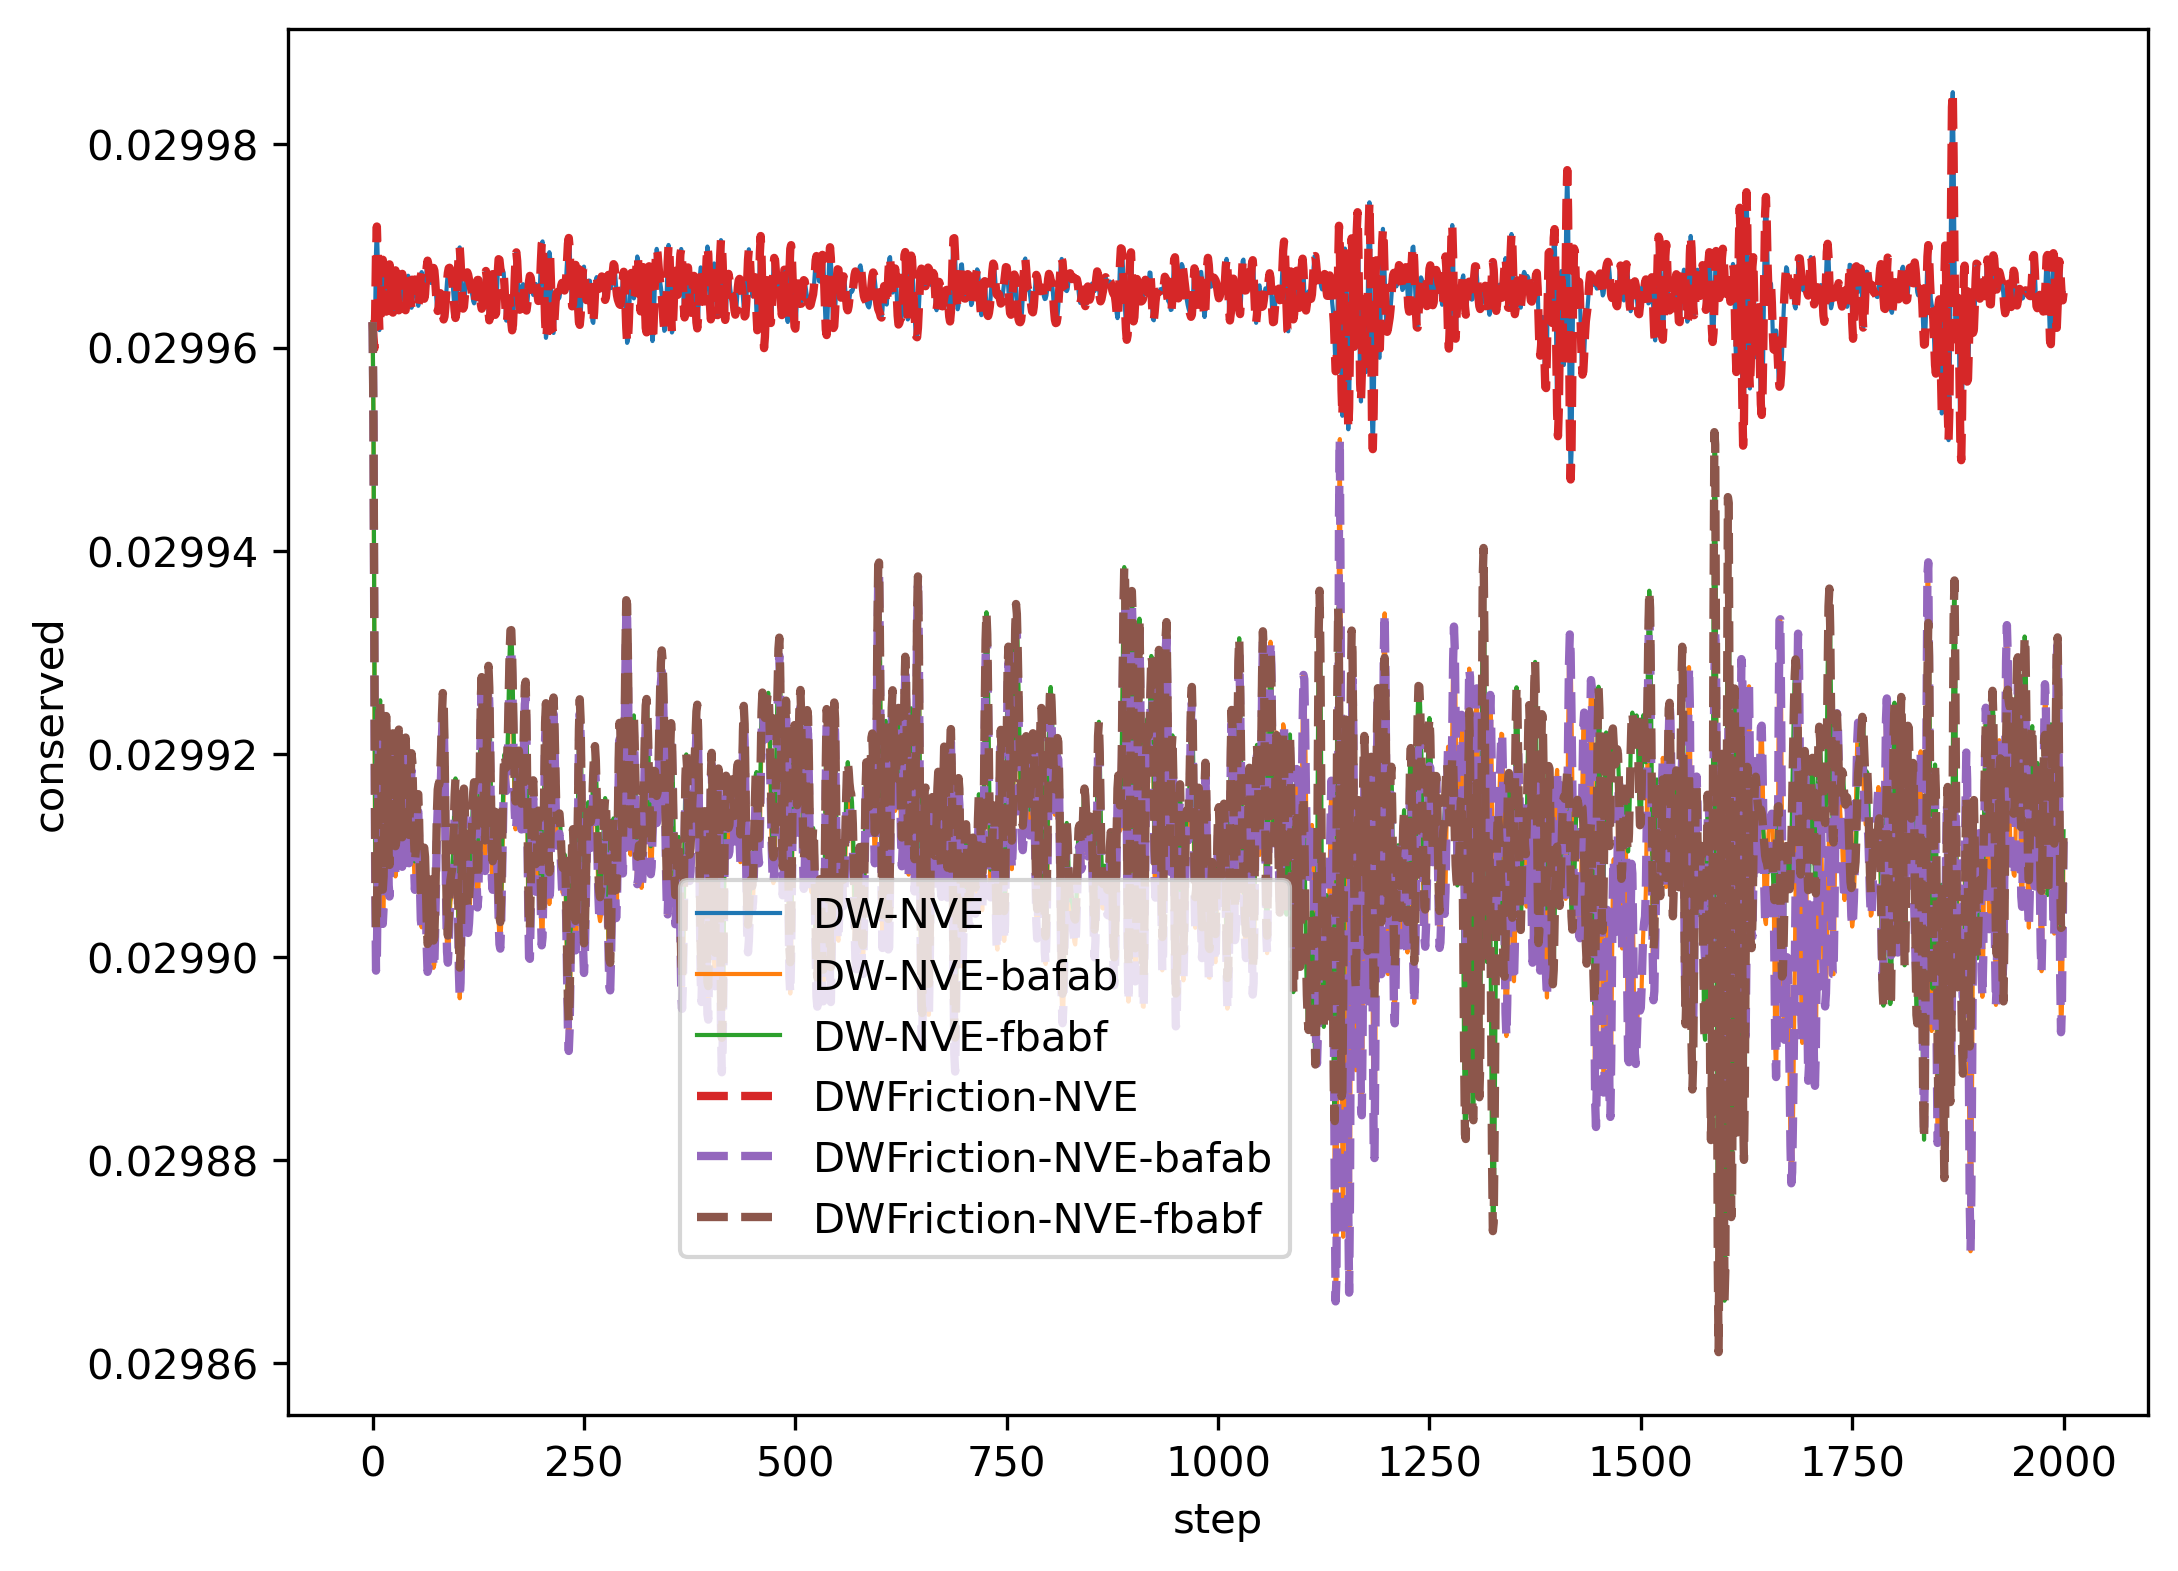

In [11]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
#quantity = "potential{electronvolt}"
quantity = "conserved"
#quantity = "temperature{kelvin}"
#quantity = "kinetic_md"
for simulation, df in data.items():
    if simulation.startswith("DWBath") or "NVT" in simulation:
        continue
    ax.plot(
        df["step"],
        df[quantity],
        label=simulation,
        linestyle="--" if simulation.startswith("DWFriction") else "-",
        linewidth=2 if simulation.startswith("DWFriction") else 1,
    )
    ax.set_xlabel("step")
    ax.set_ylabel(quantity)
    ax.legend( bbox_to_anchor=(0.55, 0.25), loc='right')

plt.show()  
# save in figures directory 
#fig.savefig(f"figures/NVE-{quantity}.png")

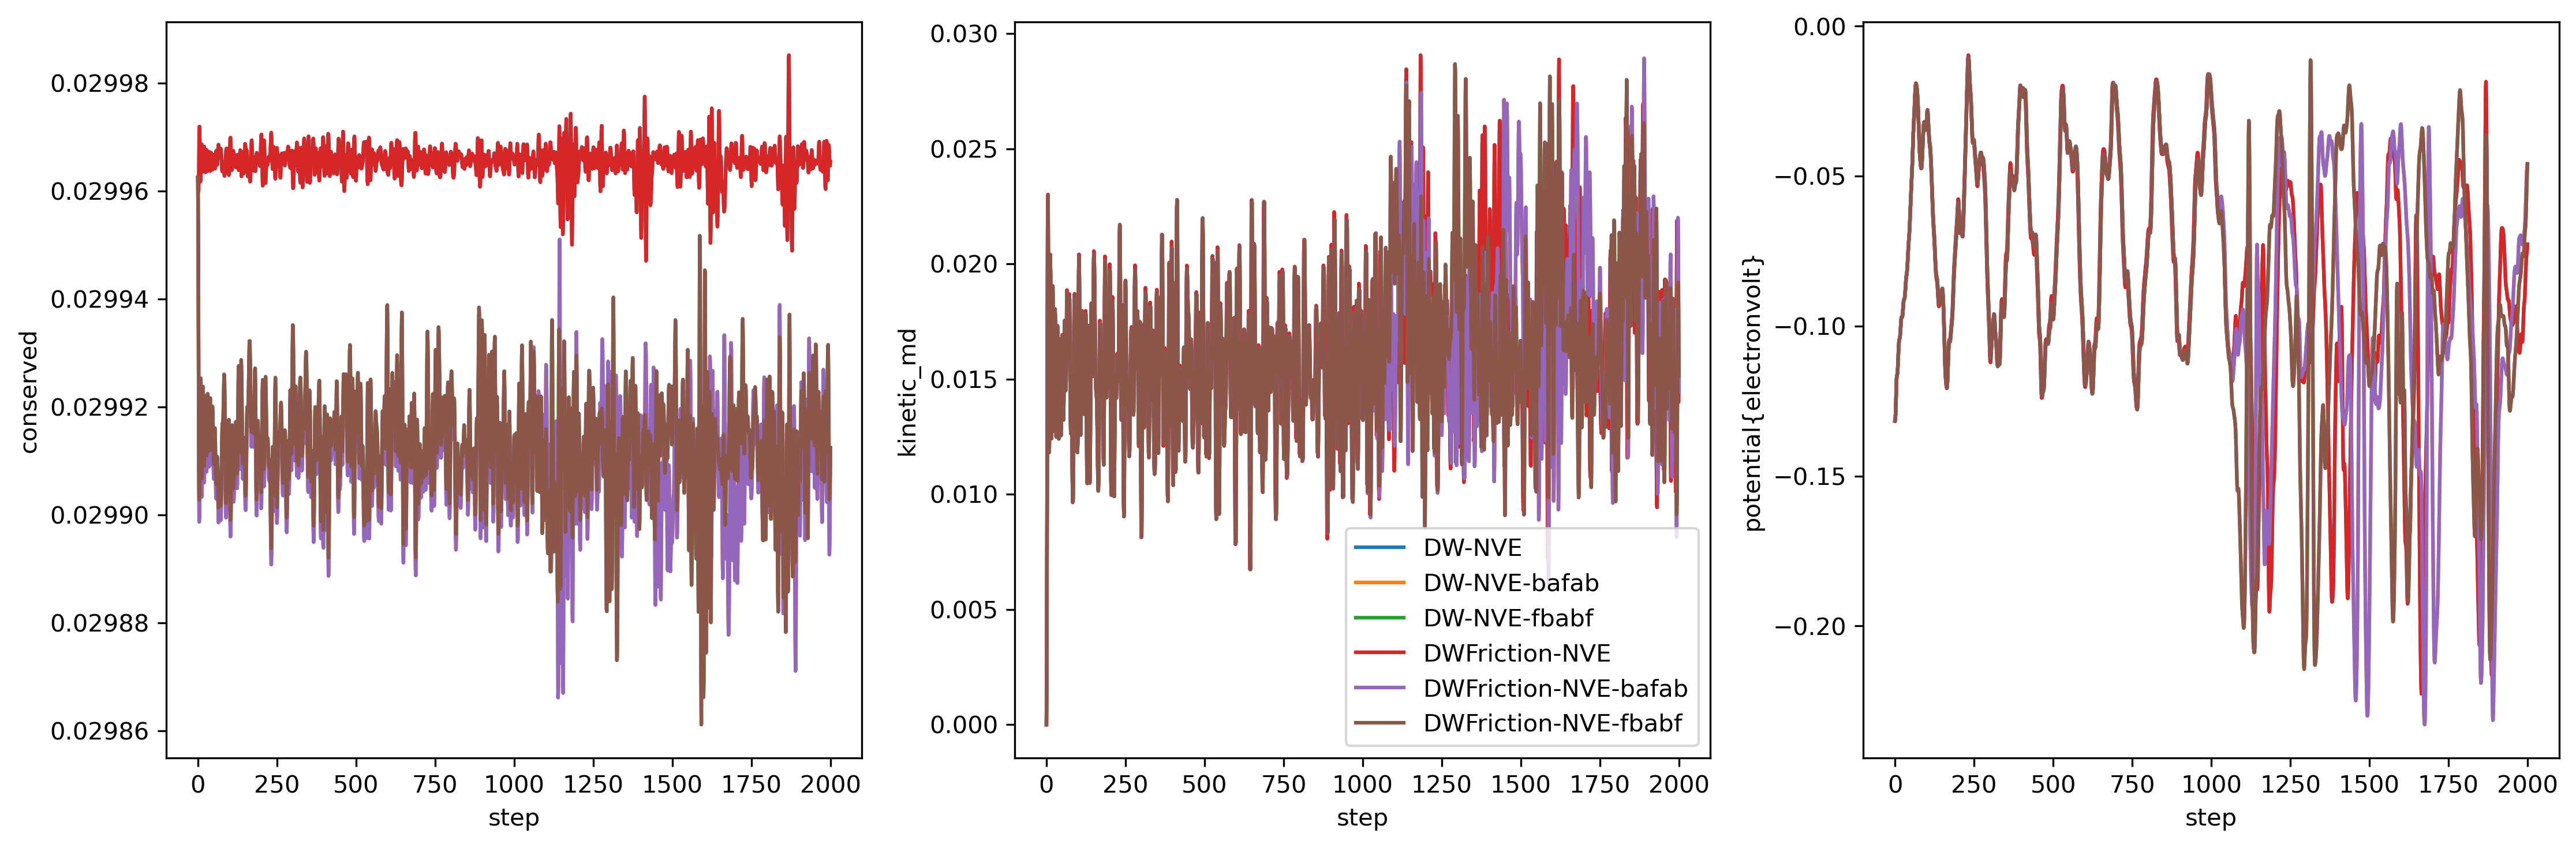

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, tight_layout=True)
for ax, quantity in zip(axes, ["conserved", "kinetic_md", "potential{electronvolt}"]):
    for simulation, df in data.items():
        if simulation.startswith("DWBath") or "NVT" in simulation:
            continue
        ax.plot(
            df["step"],
            df[quantity],
            label=simulation,
        )
    ax.set_xlabel("step")
    ax.set_ylabel(quantity)
    if quantity == "kinetic_md":
        ax.legend()
plt.show()

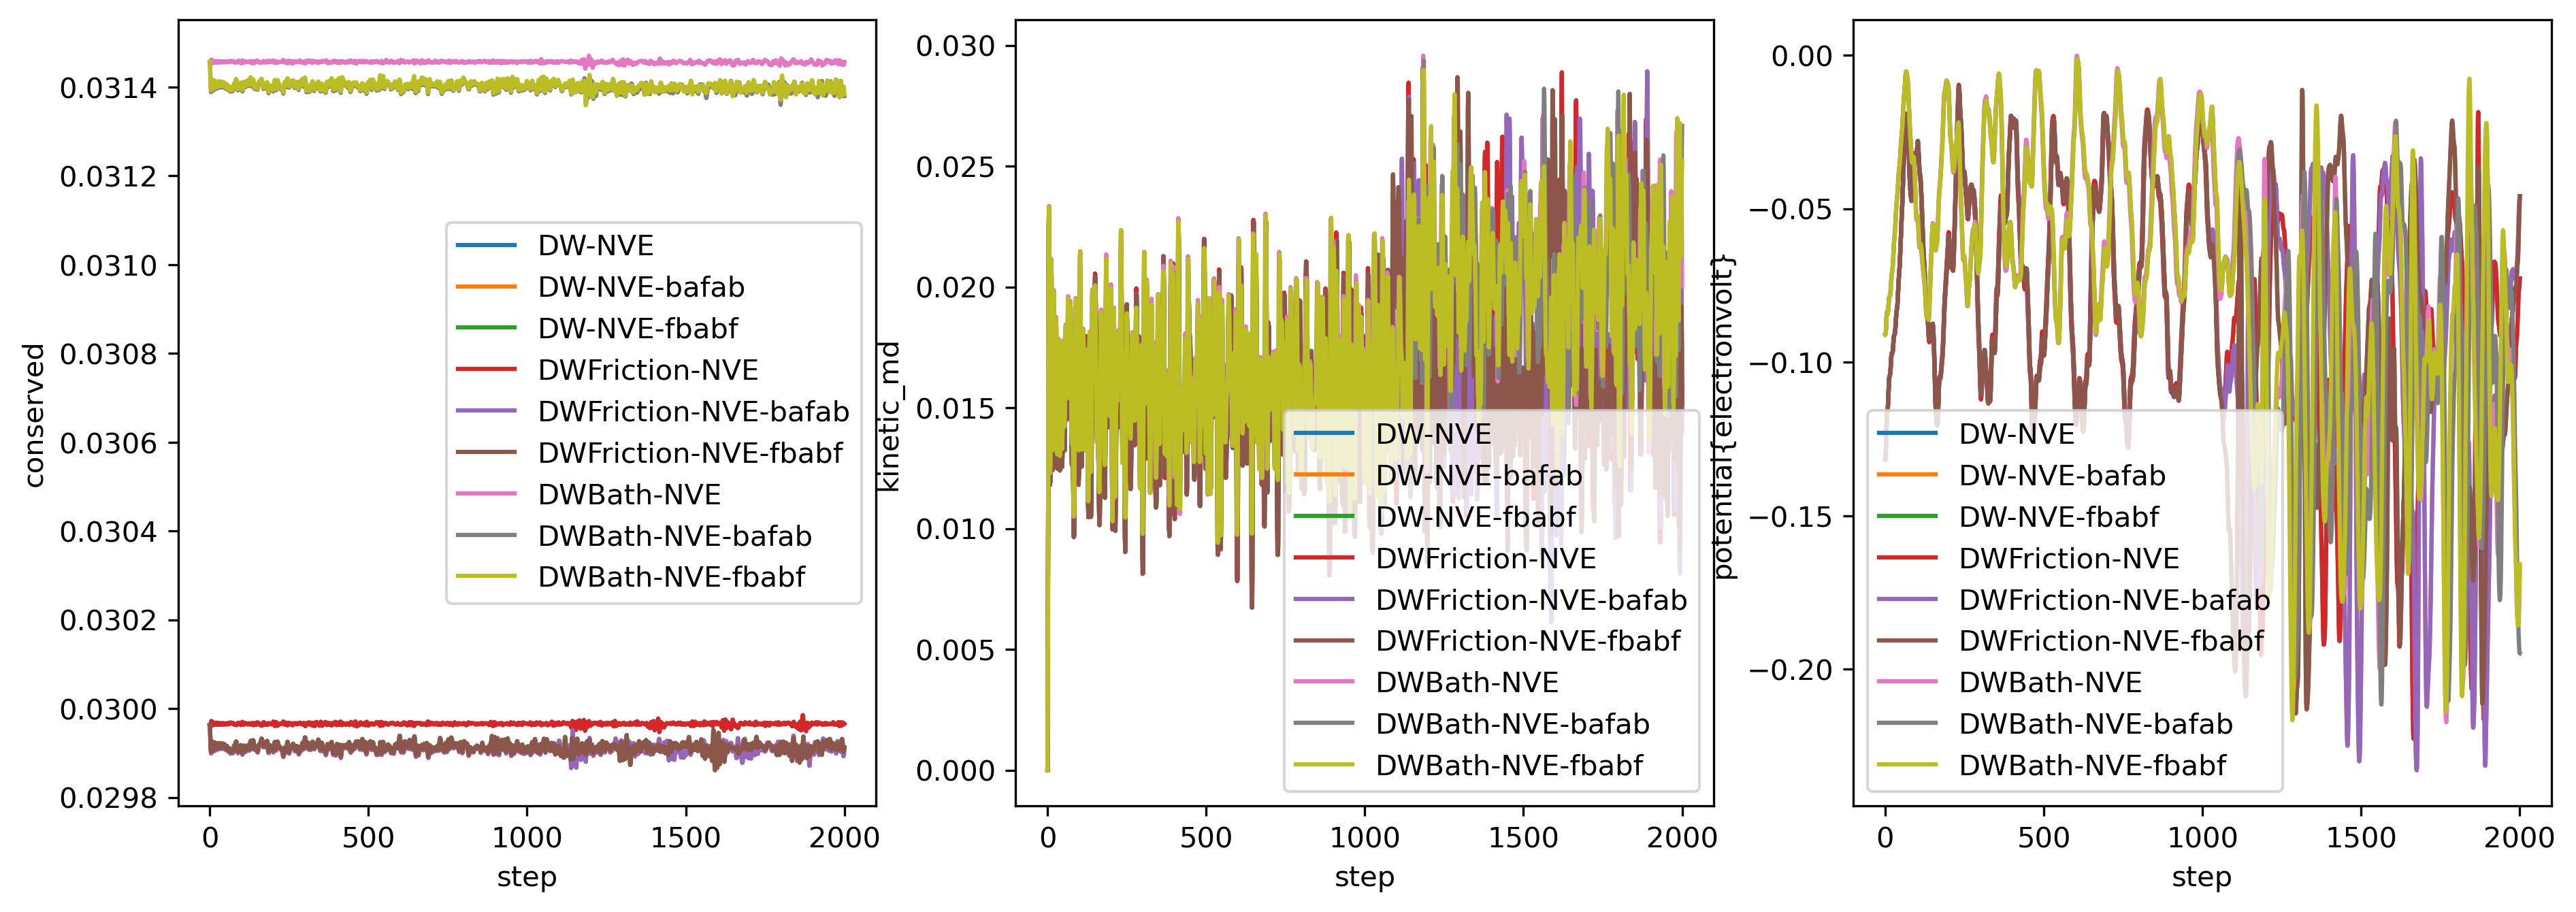

In [9]:
import matplotlib.pyplot as plt
# Make three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
for ax, quantity in zip(axes, ["conserved", "kinetic_md", "potential{electronvolt}"]):
    for simulation, df in data.items():
        if "NVT" in simulation:
            continue
        ax.plot(
            df["step"],
            df[quantity],
            label=simulation,
        )
    ax.set_xlabel("step")
    ax.set_ylabel(quantity)
    ax.legend()
plt.show()  


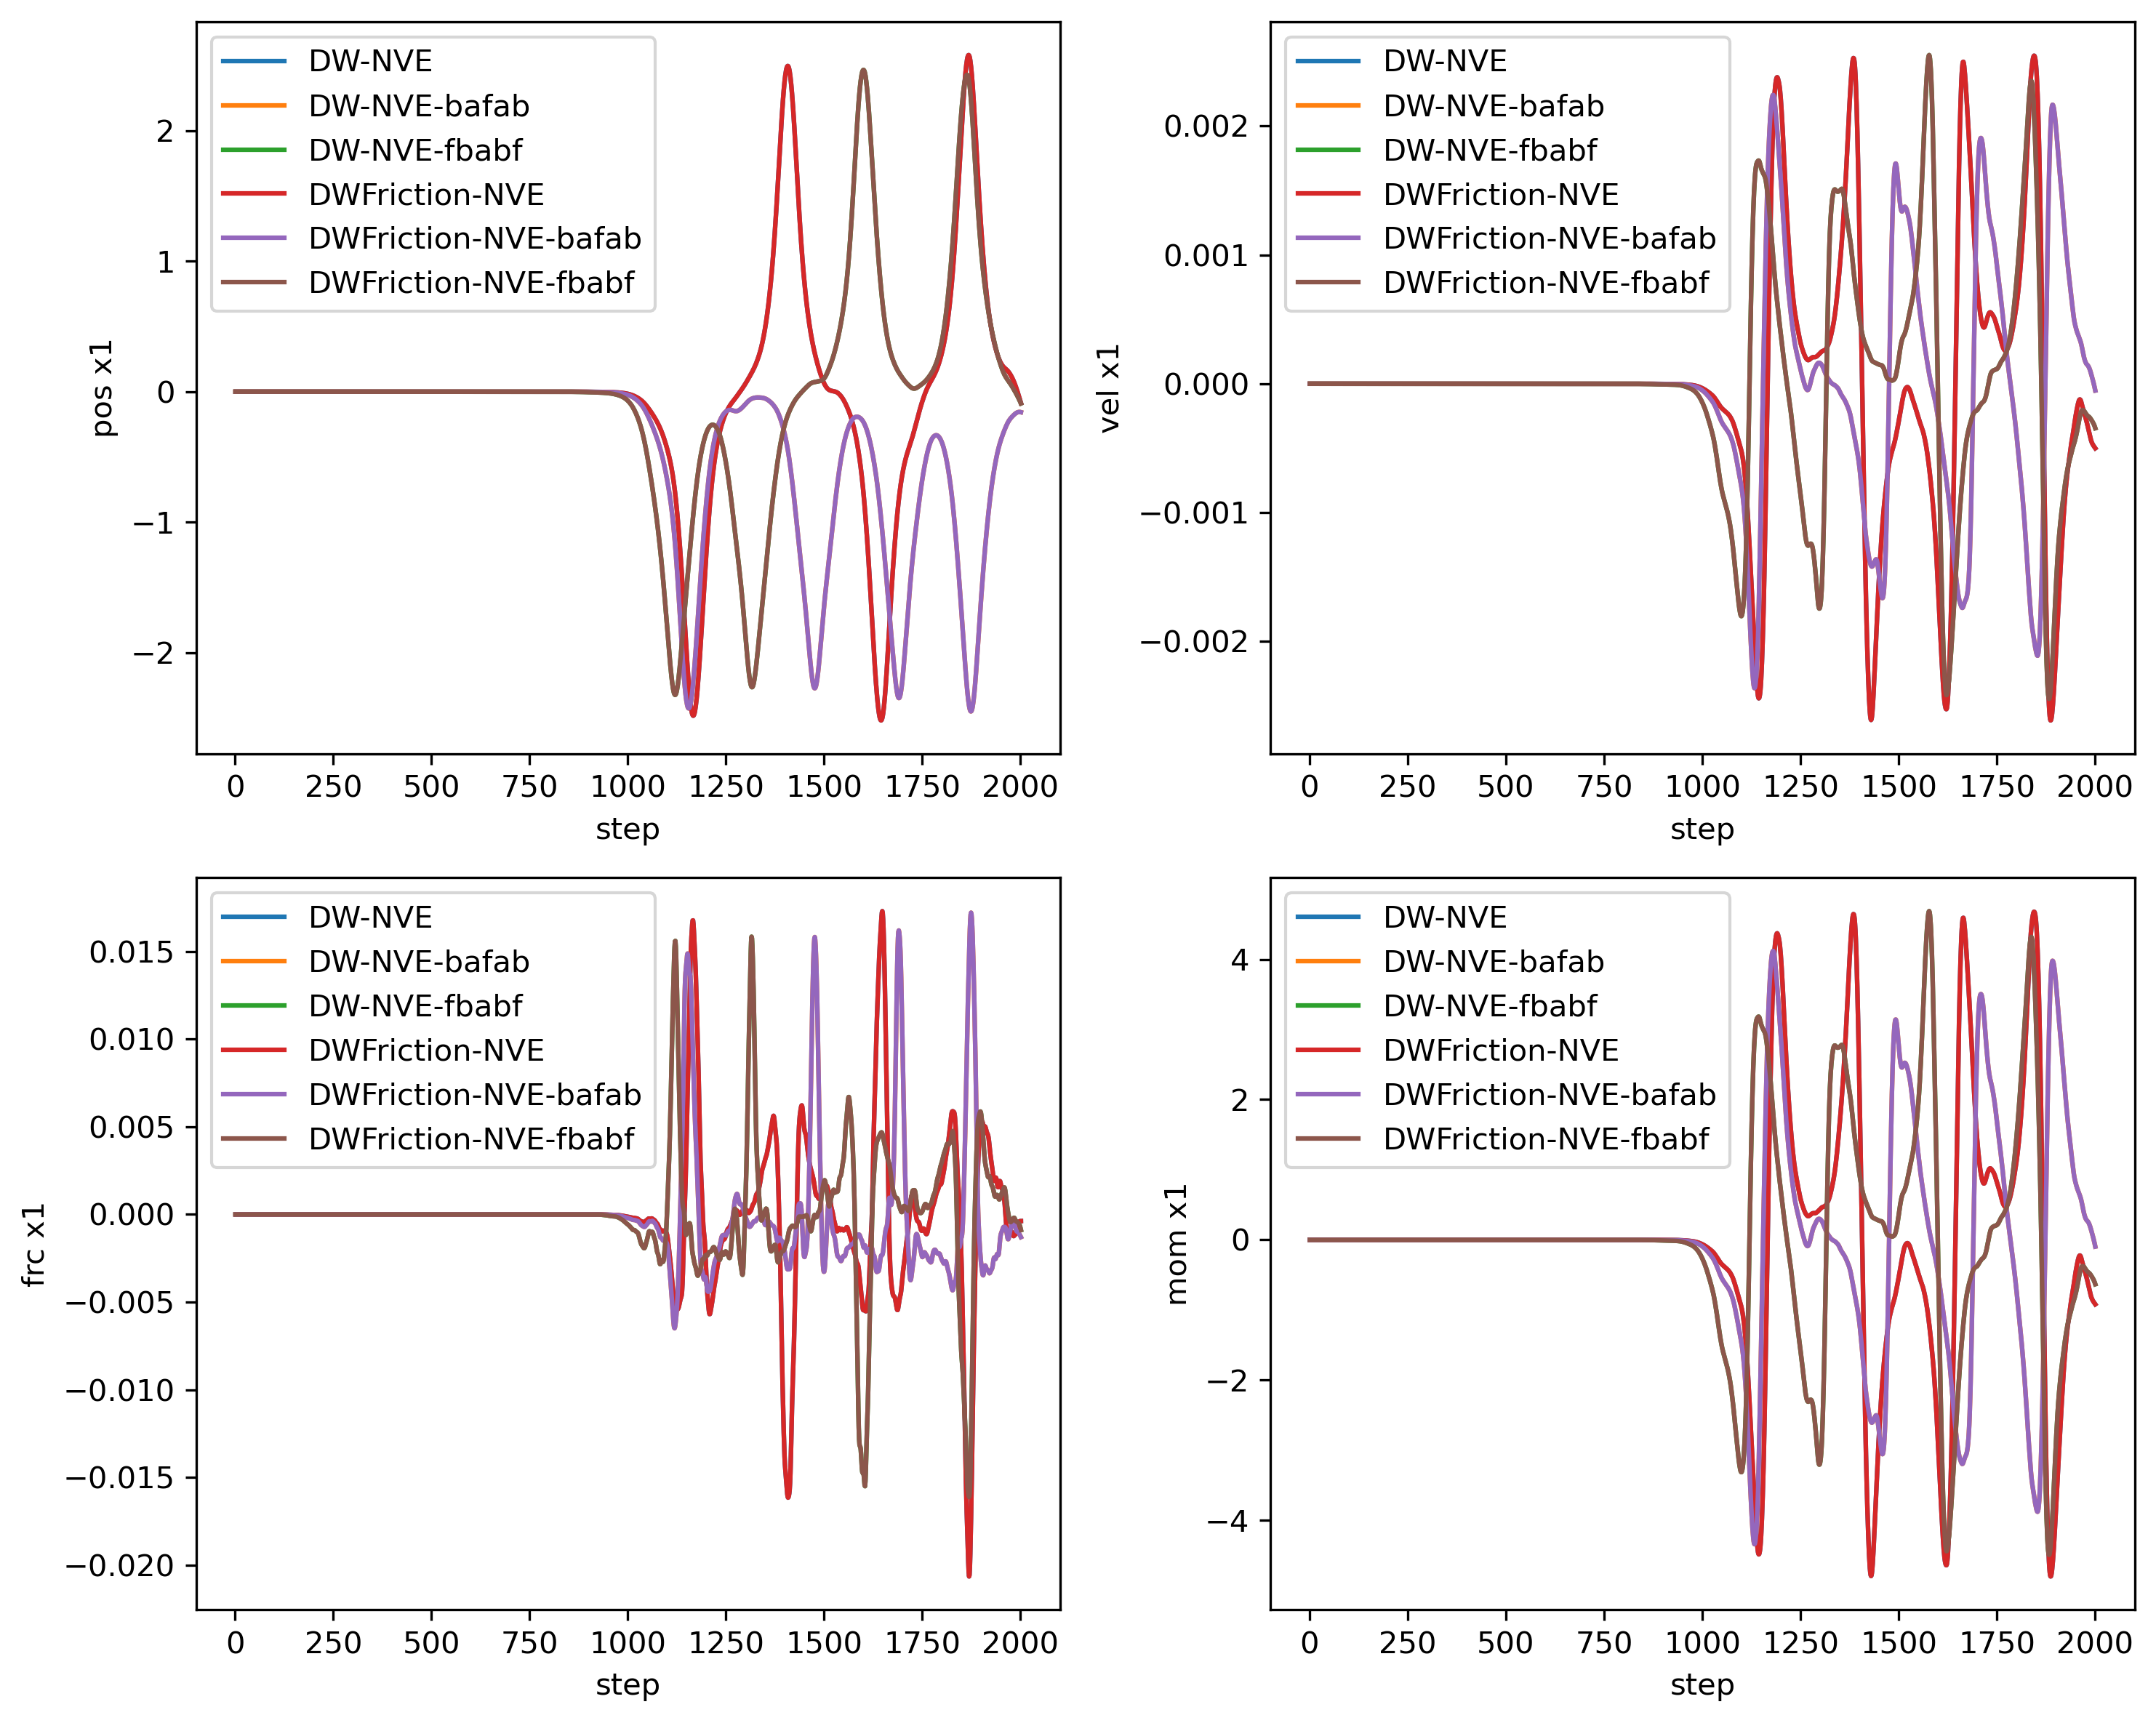

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, tight_layout=True)

for ax, prop in zip((axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]), PROPERTIES):
    quantity = f"x1"
    for simulation, df in traj.items():
        if simulation.startswith("DWBath") or "NVT" in simulation:
            continue
        ax.plot(
            df[f"{prop}_step"],
            df[f"{prop}_{quantity}"],
            label=simulation,
        )
    ax.set_xlabel("step")
    ax.set_ylabel(f"{prop} {quantity}")
    ax.legend()
plt.show()

## Compairing NVE-f (in i-PI) and NVE from George code as reference

First of all thank you George for providing the script as reference calculator.
From the reference calculator script the positions and momenta are printed for the particles and the bath.

The comparison is mostly qualitatively, because of different initial starting conditions, in i-PI example start from momenta=0 while for script momenta are initialized from a distribution. Main point of comparison is therefore the shape and dynamics as the particle moves through the double well potential.

In [13]:
def read_reference_csv(filename: str, name: str) -> pl.DataFrame:
    """Read reference positions from a CSV file into a Polars DataFrame."""
    data = {}
    with open(filename, "r") as fd:
        for line in fd.readlines():
            values = [value for value in line.split(" ") if value]
            for i, value in enumerate(values):
                key = f"{name}_col{i}"
                if key not in data:
                    data[key] = []
                data[key].append(float(value))
    return pl.DataFrame(data)

reference = {
    prop: read_reference_csv(f"reference-gle-rpmd/{prop}.csv", prop)
    for prop in ("positions", "momenta")
}

In [14]:
reference["positions"].head()

positions_col0,positions_col1,positions_col2,positions_col3,positions_col4,positions_col5,positions_col6,positions_col7,positions_col8,positions_col9,positions_col10,positions_col11,positions_col12,positions_col13,positions_col14,positions_col15,positions_col16,positions_col17,positions_col18,positions_col19,positions_col20,positions_col21,positions_col22,positions_col23,positions_col24,positions_col25,positions_col26,positions_col27,positions_col28,positions_col29,positions_col30,positions_col31,positions_col32
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41.341373,-0.025808,0.000623,0.012103,0.003265,0.015475,0.046887,-0.022079,0.013802,-0.026366,0.00452,-0.007501,0.020776,-0.013046,0.007378,-0.021287,-0.035361,0.006831,0.028521,0.008783,-0.015835,0.004241,0.013125,0.019109,-0.017822,0.010892,0.006009,-0.000347,-0.000132,-0.011289,-0.009731,0.021375,0.004058
82.682747,-0.042164,-0.001203,0.020812,0.010146,0.034102,0.077141,-0.026776,0.015125,-0.040994,0.002016,-0.008413,0.031268,-0.017163,0.006575,-0.040147,-0.061266,0.010227,0.050018,0.01678,-0.024133,0.006702,0.025679,0.031132,-0.024689,0.01626,0.011729,0.0004,-0.002151,-0.020399,-0.014541,0.034613,0.006016
124.02412,-0.043545,-0.006105,0.024086,0.022968,0.055864,0.083042,-0.007276,0.000405,-0.039223,-0.009222,-0.001154,0.027143,-0.009426,-0.005989,-0.054734,-0.071611,0.008302,0.059147,0.02354,-0.020305,0.00733,0.035858,0.033042,-0.015379,0.01417,0.016256,0.002602,-0.006763,-0.025391,-0.01214,0.03478,0.004695
165.36549,-0.030503,-0.012098,0.022213,0.041631,0.076694,0.069472,0.028547,-0.02194,-0.025869,-0.024003,0.009341,0.012199,0.004805,-0.027308,-0.06398,-0.065697,0.001477,0.05366,0.028965,-0.004344,0.008269,0.040741,0.027439,0.007028,0.007628,0.018122,0.005502,-0.012873,-0.02496,-0.004136,0.02199,0.000334


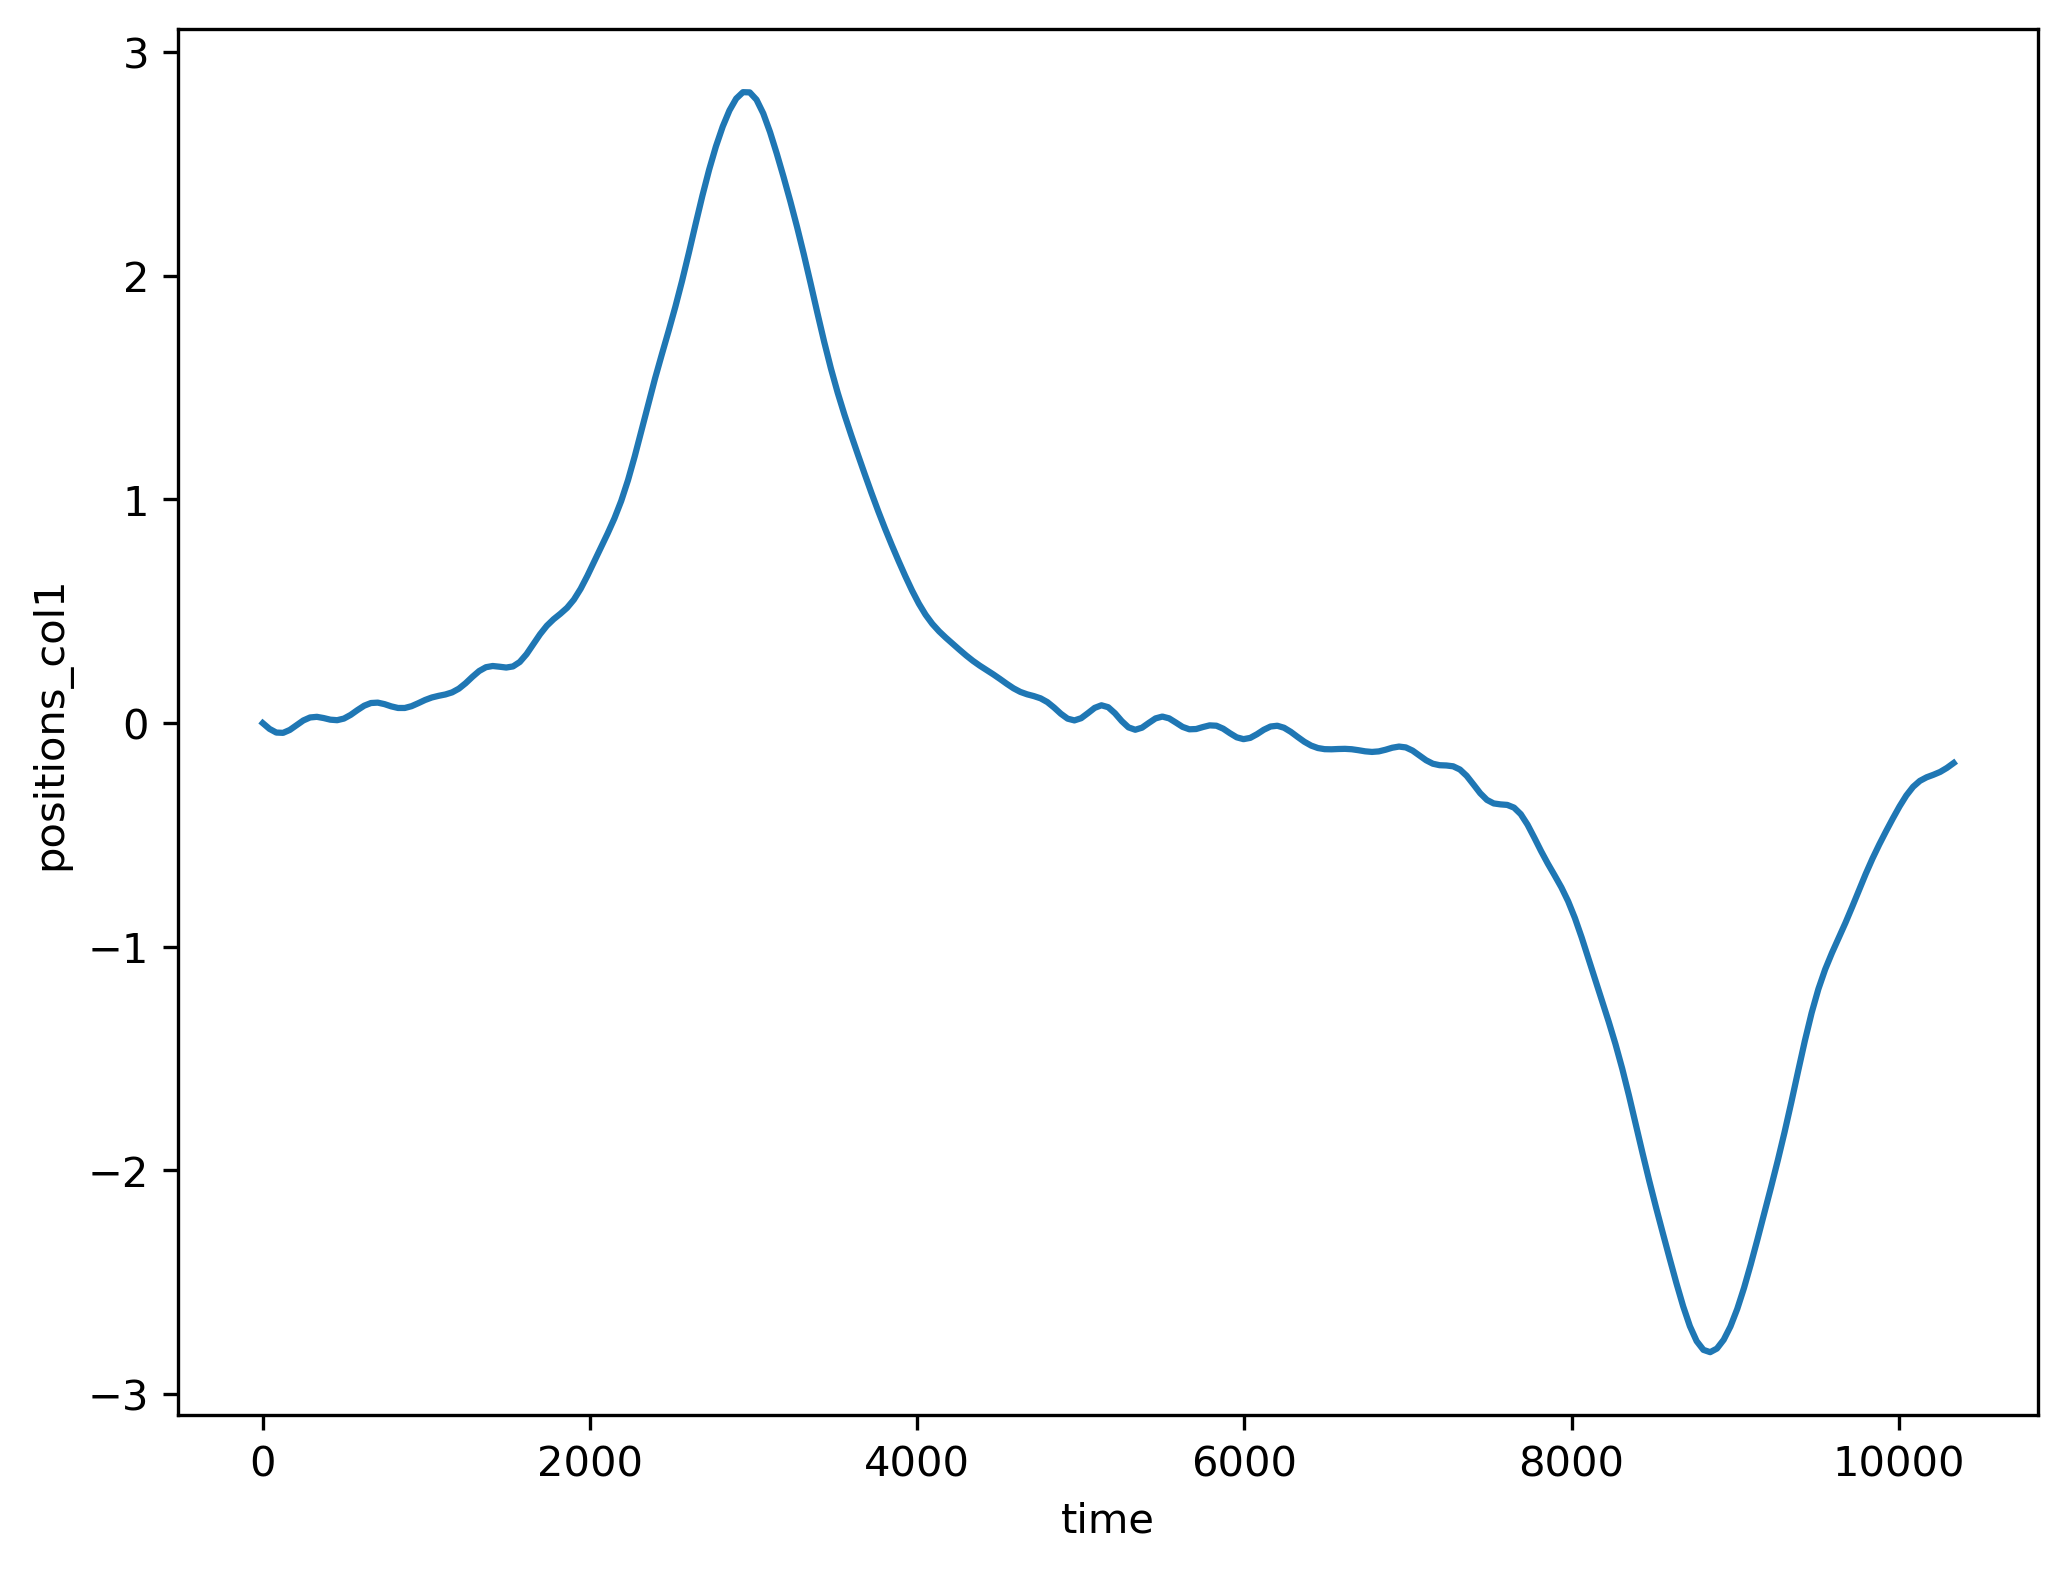

In [15]:
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(reference["positions"]["positions_col0"], reference["positions"]["positions_col1"])
plt.xlabel("time")
plt.ylabel("positions_col1")
plt.show()